In [1]:
import numpy as np
from anemoi.datasets import open_dataset
from anemoi.datasets.data.grids import Cutout

!pip show anemoi-datasets

# Load the data

In [2]:
# Datasets generated with the files in tools/grids/
data_dir = dir_with_your_zarr_data' 
f_global = data_dir + '/grids1.zarr'
f_lam1 = data_dir + '/grids2.zarr'
f_lam2 = data_dir + '/grids3.zarr'
f_lam3 = data_dir + '/grids4.zarr'
f_lam4 = data_dir + '/grids5.zarr'
f_lam5 = data_dir + '/grids6.zarr'
f_lam6 = data_dir + '/grids7.zarr'

In [3]:
global_dataset = open_dataset(f_global)
lam_dataset_1 = open_dataset(f_lam1)
lam_dataset_2 = open_dataset(f_lam2)
lam_dataset_3 = open_dataset(f_lam3)
lam_dataset_4 = open_dataset(f_lam4)
lam_dataset_5 = open_dataset(f_lam5)
lam_dataset_6 = open_dataset(f_lam6)

In [4]:
global_dataset.shape

(4, 14, 1, 65160)

In [5]:
global_dataset.variables

['10u',
 '10v',
 '2t',
 'cos_latitude',
 'cp',
 'lsm',
 'q_100',
 'q_50',
 'sin_latitude',
 't_100',
 't_50',
 'tp',
 'z_100',
 'z_50']

# Define and run some tests

In [6]:
def test_cutout_initialization(lam_dataset_1, lam_dataset_2, global_dataset):
    """ Ensure that the Cutout class correctly initializes with multiple Limited 
    Area Models (LAMs) and a global dataset"""
    cutout = Cutout(
        [lam_dataset_1, lam_dataset_2, global_dataset], 
        axis=3,
        #adjust="all",
        )
    
    assert len(cutout.lams) == 2
    assert cutout.globe is not None
    assert len(cutout.masks) == 2

def test_cutout_mask_generation(lam_dataset, global_dataset):
    """" Ensure that the cutout_mask function correctly generates masks for LAMs 
    and excludes overlapping regions."""
    cutout = Cutout(
        [lam_dataset, global_dataset], axis=3)
    mask = cutout.masks[0]
    lam = cutout.lams[0]
    
    assert mask is not None
    assert isinstance(mask, np.ndarray)
    assert isinstance(cutout.global_mask, np.ndarray)
    assert mask.shape[-1] == lam.shape[-1]
    assert cutout.global_mask.shape[-1] == global_dataset.shape[-1]
    
    
def test_cutout_getitem(lam_dataset, global_dataset):
    """ Verify that the __getitem__ method correctly returns the appropriate 
    data when indexing the Cutout object """
    cutout = Cutout([lam_dataset, global_dataset], axis=3)
    
    data = cutout[0, :, :, :]
    expected_shape = cutout.shape[1:]
    assert data is not None
    assert data.shape == expected_shape
    
def test_latitudes_longitudes_concatenation(lam_dataset_1, lam_dataset_2, global_dataset):
    """ Ensure that latitudes and longitudes are correctly 
    concatenated from all LAMs and the masked global dataset."""
    cutout = Cutout(
        [lam_dataset_1, lam_dataset_2, global_dataset], 
        axis=3
        )
    
    latitudes = cutout.latitudes
    longitudes = cutout.longitudes
    
    assert latitudes is not None
    assert longitudes is not None
    assert len(latitudes) == cutout.shape[-1]
    assert len(longitudes) == cutout.shape[-1]
    
def test_overlapping_lams(lam_dataset_1, lam_dataset_2, global_dataset):
    """ Confirm that overlapping regions between LAMs and the global dataset are 
    correctly handled by the masks."""
    # lam_dataset_2 has to overlap with lam_dataset_1
    cutout = Cutout(
        [lam_dataset_1, lam_dataset_2, global_dataset], 
        axis=3
        )
    
    # Verify that the overlapping region in lam_dataset_2 is excluded
    assert np.count_nonzero(cutout.masks[1] == False) > 0
    
def test_open_dataset_cutout(lam_dataset_1, global_dataset):
    """ Ensure that open_dataset(cutout=[...]) works correctly with the new 
    Cutout implementation"""
    ds = open_dataset(
        cutout=[lam_dataset_1, global_dataset]
        )

    assert isinstance(ds, Cutout)
    assert len(ds.lams) == 1
    assert ds.globe is not None
    
    
def test_large_cutout_performance(large_lam_dataset, large_global_dataset):
    """  Visually confirm that the masked regions are correct"""
    cutout = Cutout(
        [large_lam_dataset, large_global_dataset], 
        axis=3
        )
    
    data = cutout[0, :, :, :]
    assert data is not None

In [7]:
test_cutout_initialization(lam_dataset_1, lam_dataset_2, global_dataset)

In [8]:
test_cutout_mask_generation(lam_dataset_1, global_dataset)
    

In [9]:
test_cutout_getitem(lam_dataset_1, global_dataset)

In [10]:
test_latitudes_longitudes_concatenation(lam_dataset_1, lam_dataset_2, global_dataset)

In [11]:
test_overlapping_lams(lam_dataset_1, lam_dataset_2, global_dataset)

In [12]:
test_open_dataset_cutout(lam_dataset_1, global_dataset)

In [13]:

test_large_cutout_performance(lam_dataset_1, global_dataset)

# Plot function

In [14]:
def plot_grid(ds, path, s=0.1, c="r", grids=None, point=None, central_latitude=-20.0, central_longitude=165.0):
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import numpy as np

    lats, lons = ds.latitudes, ds.longitudes

    fig = plt.figure(figsize=(9, 9))
    proj = ccrs.NearsidePerspective(
        central_latitude=central_latitude, 
        central_longitude=central_longitude, 
        satellite_height=4e6
    )

    ax = plt.axes(projection=proj)

    def fill():
        # Make sure we have a full globe
        lons, lats = np.meshgrid(np.arange(-180, 180, 1), np.arange(-90, 90, 1))
        x, y, _ = proj.transform_points(
            ccrs.PlateCarree(), lons.flatten(), lats.flatten()
        ).T

        mask = np.invert(np.logical_or(np.isinf(x), np.isinf(y)))
        x = np.compress(mask, x)
        y = np.compress(mask, y)

        # ax.tricontourf(x, y, values)
        ax.scatter(x, y, s=0, c="w")

    fill()

    def plot(what, s, c):
        x, y, _ = proj.transform_points(ccrs.PlateCarree(), lons[what], lats[what]).T

        mask = np.invert(np.logical_or(np.isinf(x), np.isinf(y)))
        x = np.compress(mask, x)
        y = np.compress(mask, y)

        # ax.tricontourf(x, y, values)
        ax.scatter(x, y, s=s, c=c)

    if grids:
        #print('s: ', s)
        a = 0
        for i, b in enumerate(grids):
            if s[i] is not None:
                plot(slice(a, a + b), s[i], c[i])
            a += b
    else:
        plot(..., s, c)

    if point:
        point = np.array(point, dtype=np.float64)
        x, y, _ = proj.transform_points(ccrs.PlateCarree(), point[1], point[0]).T
        ax.scatter(x, y, s=100, c="k")

    ax.coastlines()

    if isinstance(path, str):
        fig.savefig(path, bbox_inches="tight")
    else:
        for p in path:
            fig.savefig(p, bbox_inches="tight")

# 1) Plot the datasets separately

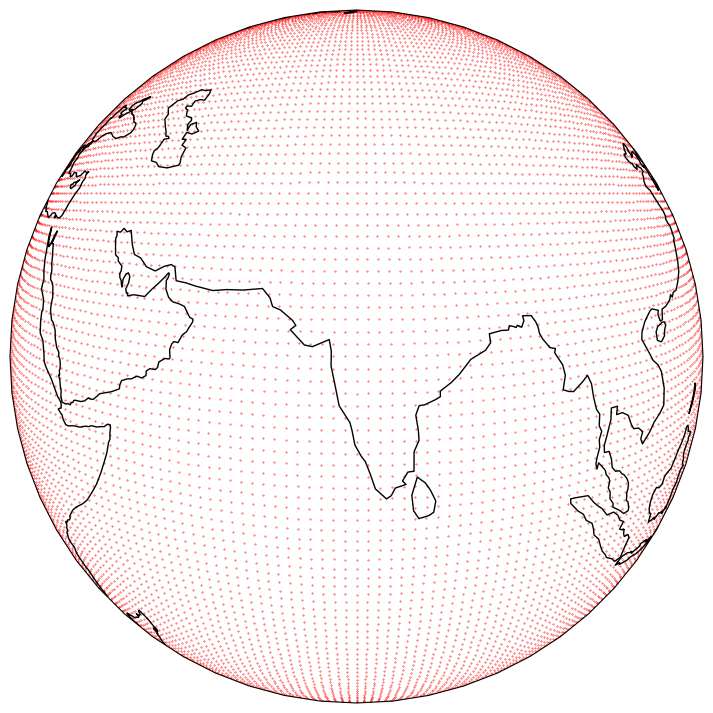

In [15]:
plot_grid(global_dataset, "global_grids1.png", central_latitude=20.0, central_longitude=75.0)

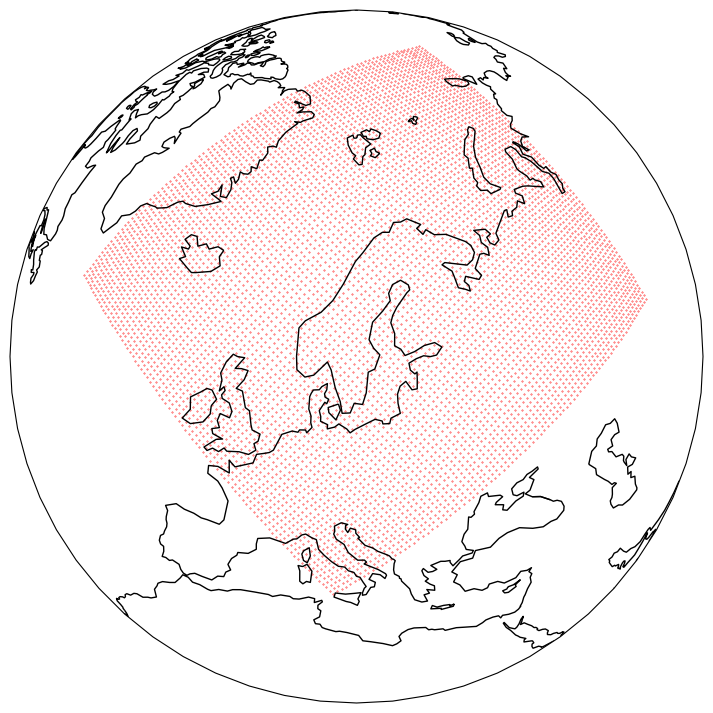

In [16]:
plot_grid(lam_dataset_1, "lam1_grids2.png", central_latitude=60.0, central_longitude=15.0)

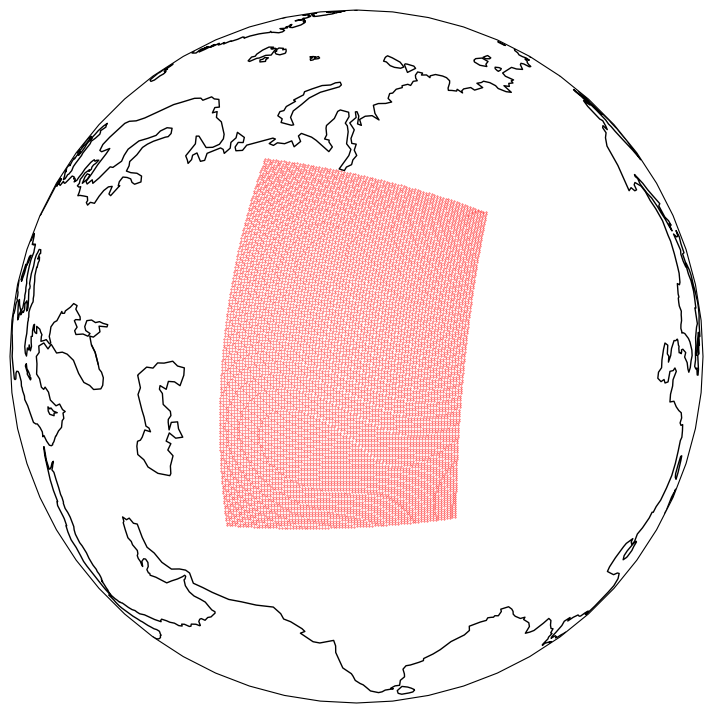

In [17]:
plot_grid(lam_dataset_2, "lam1_grids3.png", central_latitude=50.0, central_longitude=75.0)

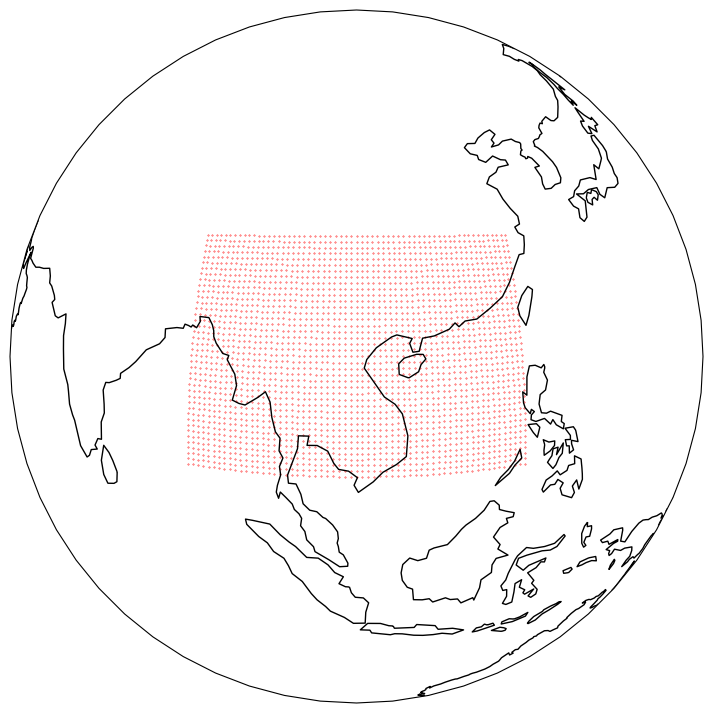

In [18]:
plot_grid(lam_dataset_3, "lam1_grids4.png", central_latitude=20.0, central_longitude=105.0)

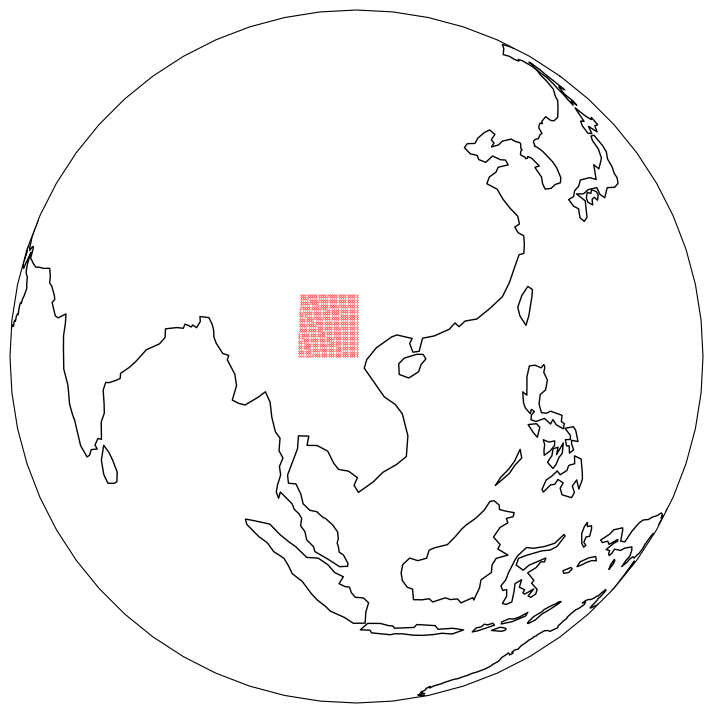

In [19]:
plot_grid(lam_dataset_4, "lam1_grids5.png", central_latitude=20.0, central_longitude=105.0)

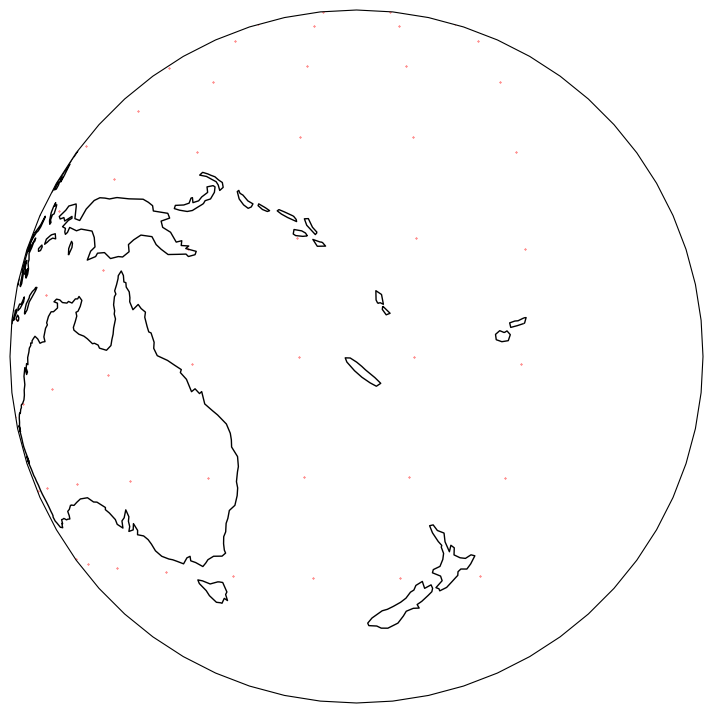

In [20]:
plot_grid(lam_dataset_5, "lam5_grids6.png", central_latitude=-20.0, central_longitude=165.0)

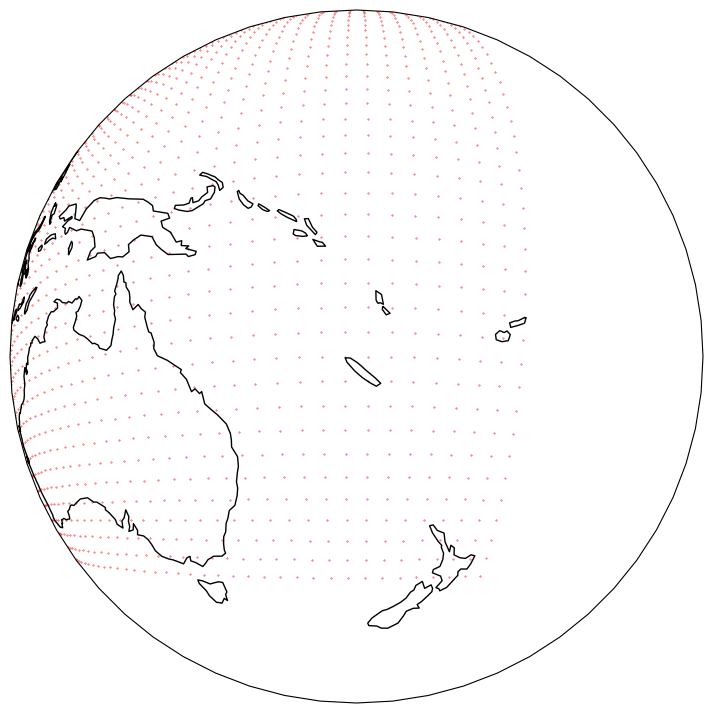

In [21]:
plot_grid(lam_dataset_6, "lam6_grids7.png", central_latitude=-20.0, central_longitude=165.0)

# 2)  Test cutout with one LAM

In [22]:
ds = open_dataset(cutout=[lam_dataset_1, global_dataset])

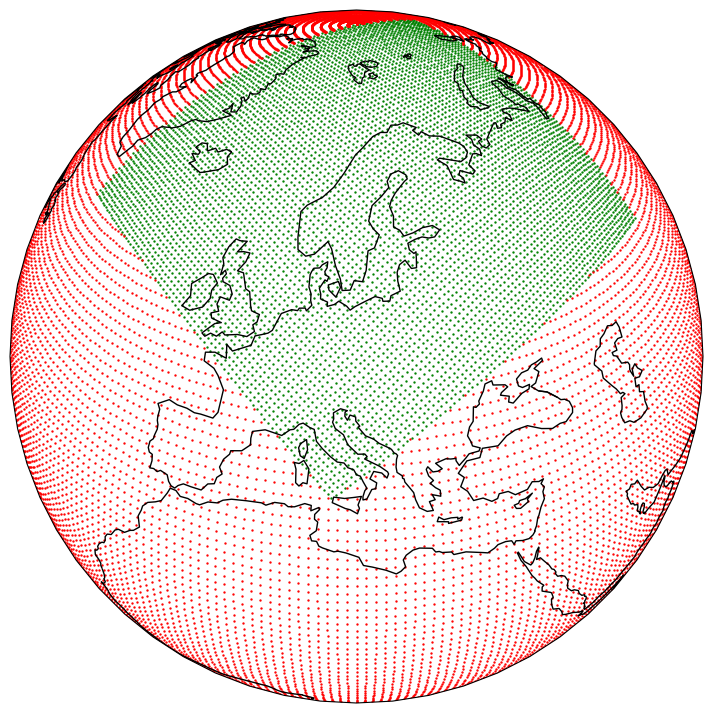

In [23]:
plot_grid(
    ds,
    "cutout_global_lam1.png",
    s=[0.5, 0.5],
    grids=ds.grids,
    c=["g", "r"],
    central_latitude=50.0, 
    central_longitude=15.0
)

# 3) a) Test two overlapping LAMs
The LAMs have different resolution and are rotated

In [24]:
ds = open_dataset(cutout=[lam_dataset_2,  lam_dataset_1, global_dataset])

In [25]:
ds.grids

(11421, 6358, 58961)

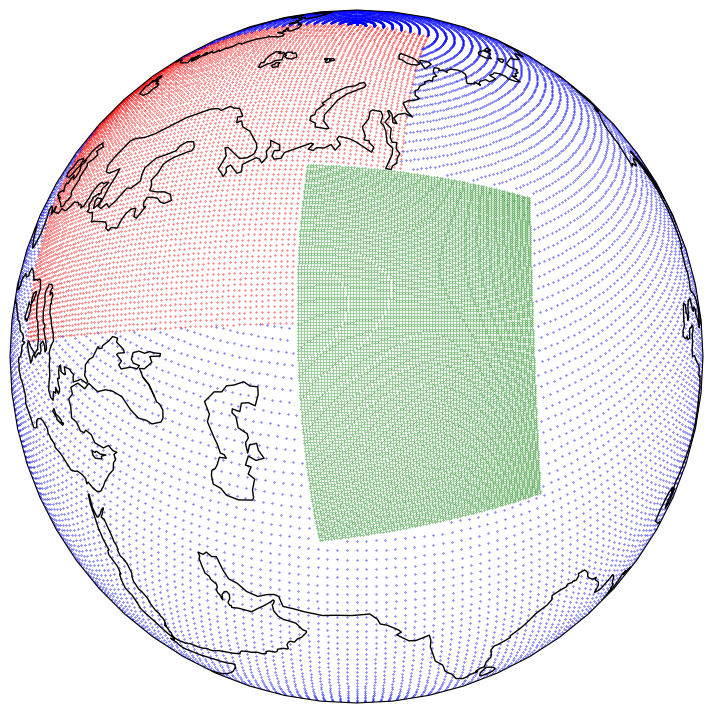

In [26]:
plot_grid(
    ds,
    "cutout_global_lam1_lam2.png",
    s=[0.1, 0.1, 0.1],
    grids=ds.grids,
    c=["g", "r", "b"],
    central_latitude=50.0, 
    central_longitude=65.0
)

## 3) b) The same LAMs but in a different order

In [27]:
ds = open_dataset(cutout=[lam_dataset_1,  lam_dataset_2, global_dataset])

In [28]:
ds.grids

(6885, 9416, 58961)

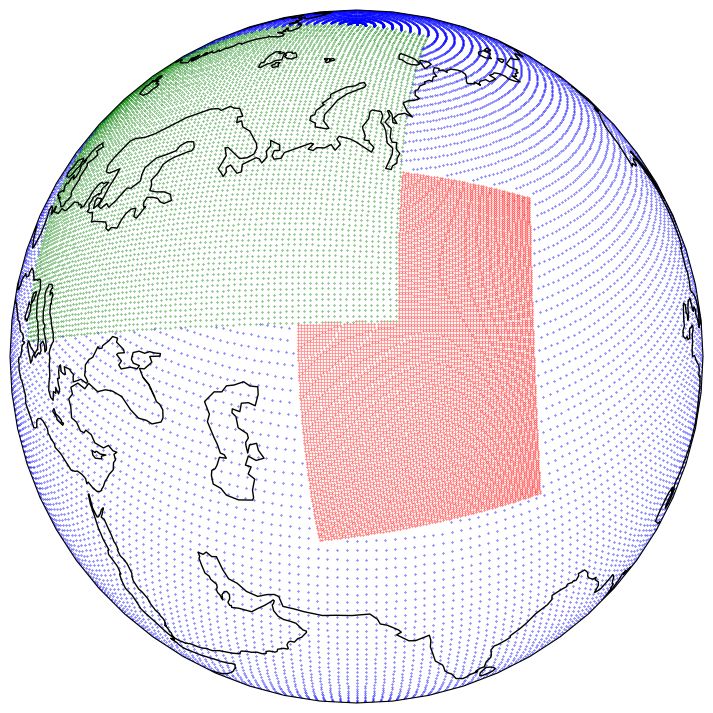

In [29]:
plot_grid(
    ds,
    "cutout_global_lam2_lam1.png",
    s=[0.1, 0.1, 0.1],
    grids=ds.grids,
    c=["g", "r", "b"],
    central_latitude=50.0, 
    central_longitude=65.0
)

# 4) Test two LAMS that are not overlapping

In [30]:
ds = open_dataset(cutout=[lam_dataset_3, lam_dataset_2, global_dataset]) 

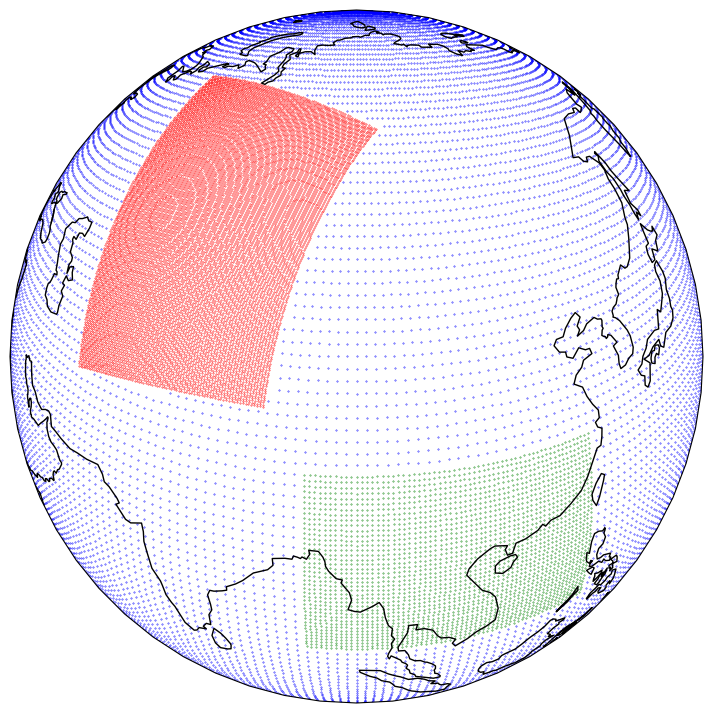

In [31]:
plot_grid(
    ds,
    "cutout_global_lam3_lam2.png",
    s=[0.1, 0.1, 0.1],
    grids=ds.grids,
    c=["g", "r", "b"],
    central_latitude=40.0, 
    central_longitude=95.0
)

# 5)  Test multiple LAMS 

- LAMs with different resolutions
- Rotated LAMs
- LAMs with no overlap.
- LAM contained within other LAM

In [32]:
#ds = open_dataset(cutout=[lam_dataset_4, lam_dataset_3, lam_dataset_2,  lam_dataset_1, lam_dataset_5, global_dataset])
ds = open_dataset(cutout=[lam_dataset_4, lam_dataset_3, lam_dataset_2,  lam_dataset_1, global_dataset])

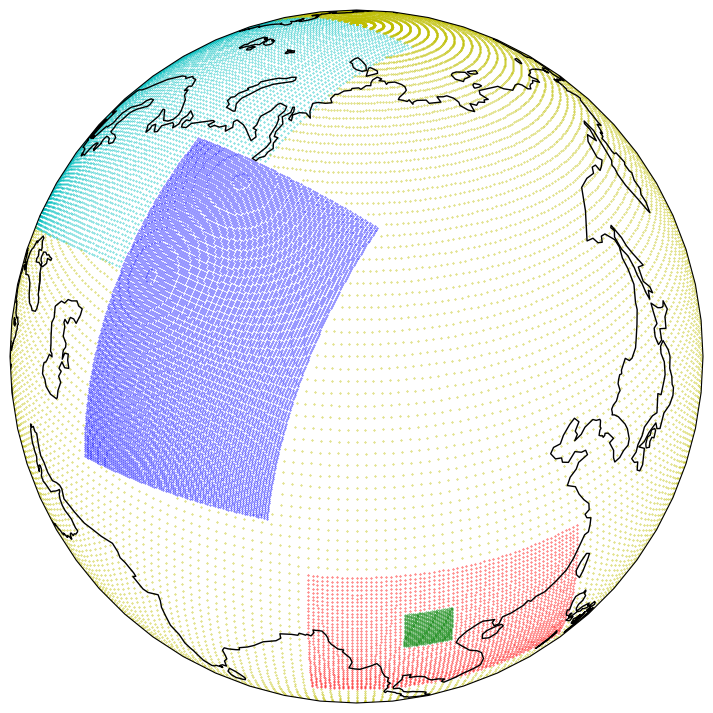

In [33]:
plot_grid(
    ds,
    # "cutout_global_lam4_lam3_lam2_lam1_lam5.png",
    "cutout_global_lam4_lam3_lam2_lam1.png",
    s=[0.1, 0.1, 0.1, 0.1, 0.1],
    grids=ds.grids,
    #c=["g", "r", "b", "c", "y", "k"],
    c=["g", "r", "b", "c", "y"],
    central_latitude=50.0, 
    central_longitude=95.0
)

# Test small LAM behind bigger LAM

In [34]:
#ds = open_dataset(cutout=[lam_dataset_4, lam_dataset_3, lam_dataset_2,  lam_dataset_1, lam_dataset_5, global_dataset])
ds = open_dataset(cutout=[lam_dataset_3, lam_dataset_4, global_dataset])

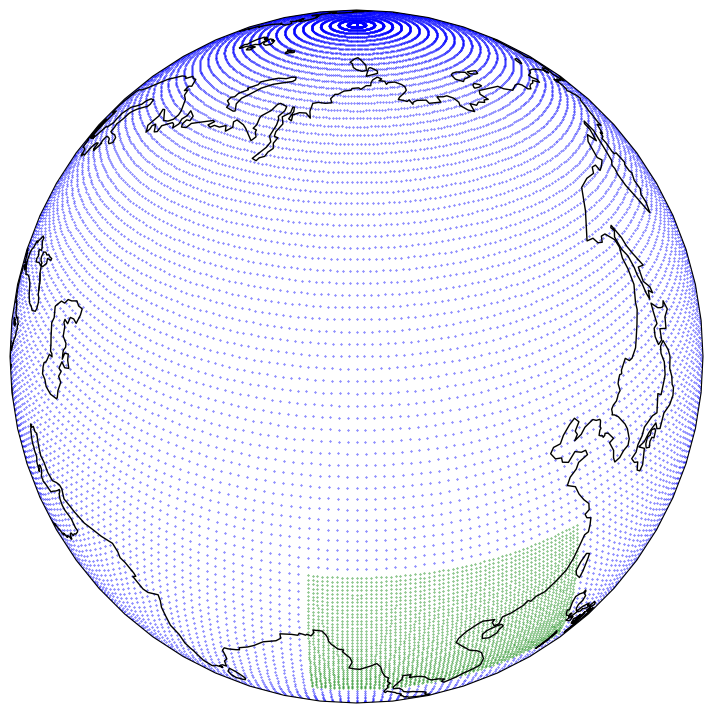

In [35]:
plot_grid(
    ds,
    # "cutout_global_lam4_lam3_lam2_lam1_lam5.png",
    "cutout_global_lam3_lam4.png",
    s=[0.1, 0.1, 0.1],
    grids=ds.grids,
    #c=["g", "r", "b", "c", "y", "k"],
    c=["g", "r", "b"],
    central_latitude=50.0, 
    central_longitude=95.0
)

# 6 a)  Test cutout with a coarser resolution LAM

Using LAMs with very low resolution can be a challenge, depending on how it compares to the resolution of the global dataset and the other LAMs.

TODO: A future implementation could consider a list of `min_distance_km` and `neighbours`, so that there is value one for each LAM.

### Using default values

In [36]:
ds = open_dataset(cutout=[lam_dataset_5, global_dataset])


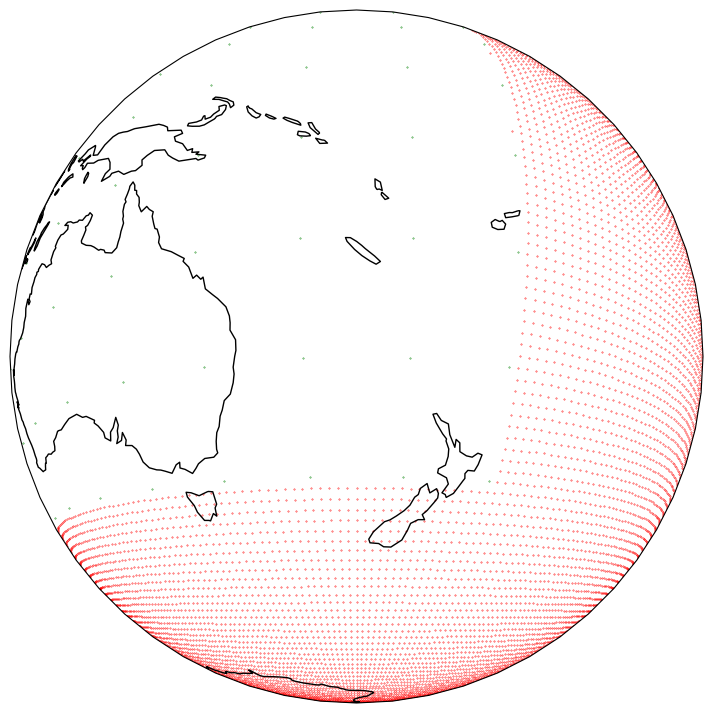

In [37]:
plot_grid(
    ds,
    "cutout_global_lam5.png",
    s=[0.1, 0.1],
    grids=ds.grids,
    c=["g", "r"],
    central_latitude=-30.0, 
    central_longitude=165.0
)

Has some issues when using default parameters

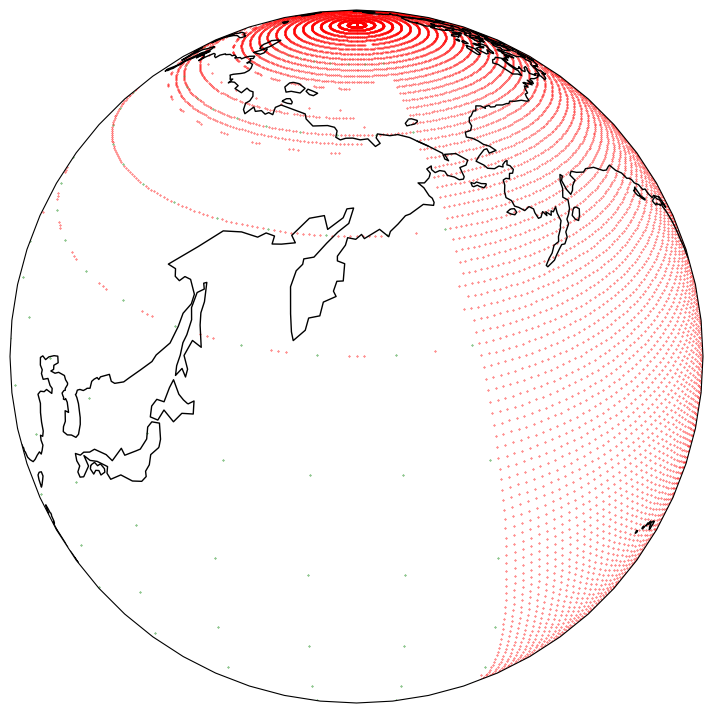

In [38]:
plot_grid(
    ds,
    "cutout_global_lam5.png",
    s=[0.1, 0.1],
    grids=ds.grids,
    c=["g", "r"],
    central_latitude=50.0, 
    central_longitude=165.0
)

### 6) a) i) Test the parameter `min_distance_km`.

In [39]:
ds = open_dataset(cutout=[lam_dataset_5, global_dataset], min_distance_km=600)


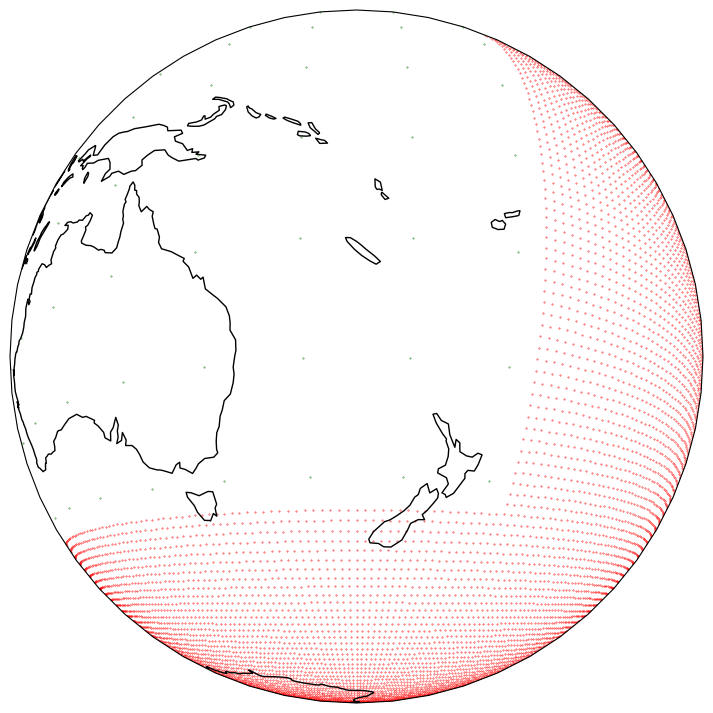

In [40]:
plot_grid(
    ds,
    "cutout_global_lam5.png",
    s=[0.1, 0.1],
    grids=ds.grids,
    c=["g", "r"],
    central_latitude=-30.0, 
    central_longitude=165.0
)

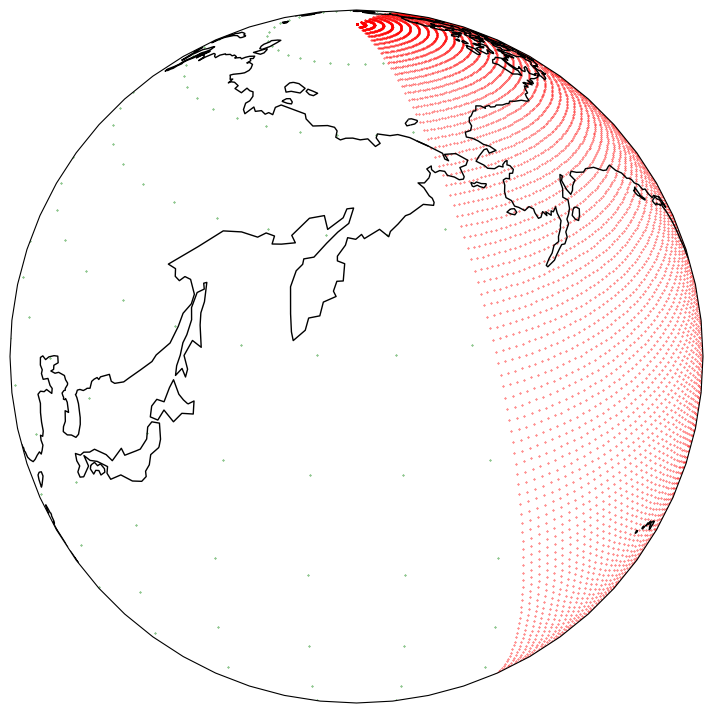

In [41]:
plot_grid(
    ds,
    "cutout_global_lam5.png",
    s=[0.1, 0.1],
    grids=ds.grids,
    c=["g", "r"],
    central_latitude=50.0, 
    central_longitude=165.0
)

### 6) a) ii) Test the parameter `neighbours`.

In [42]:
ds = open_dataset(cutout=[lam_dataset_5, global_dataset], neighbours=200)


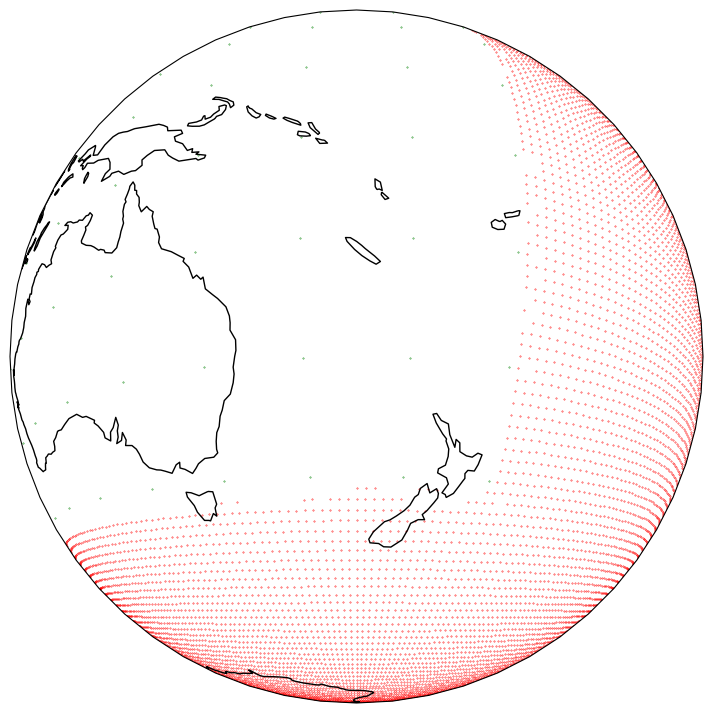

In [43]:
plot_grid(
    ds,
    "cutout_global_lam5.png",
    s=[0.1, 0.1],
    grids=ds.grids,
    c=["g", "r"],
    central_latitude=-30.0, 
    central_longitude=165.0
)

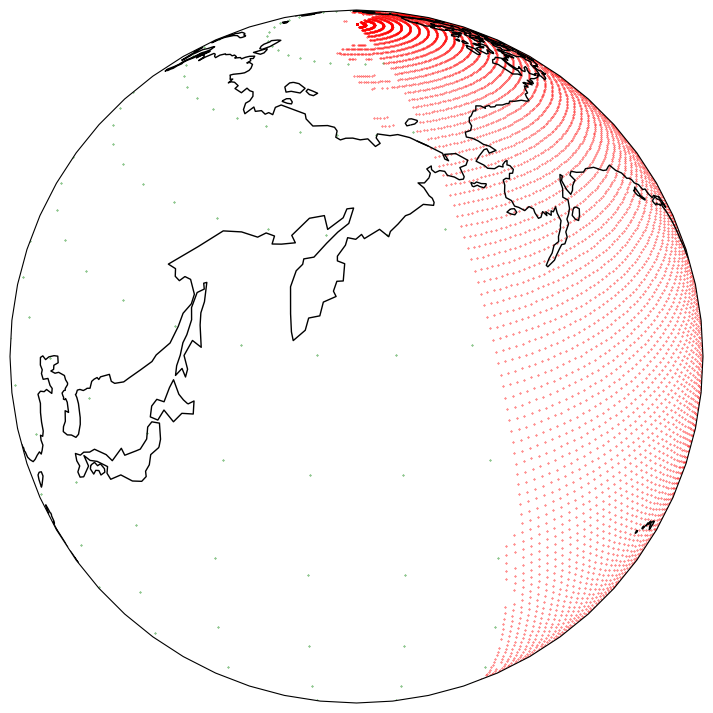

In [44]:
plot_grid(
    ds,
    "cutout_global_lam5.png",
    s=[0.1, 0.1],
    grids=ds.grids,
    c=["g", "r"],
    central_latitude=50.0, 
    central_longitude=165.0
)

## 6) b)  A similar example, where the LAM resolution is not so low

### 6) b) i) Test the parameter `min_distance_km`.

In [45]:
ds = open_dataset(cutout=[lam_dataset_4, lam_dataset_3, lam_dataset_2,  lam_dataset_1, lam_dataset_6, global_dataset], min_distance_km=200)


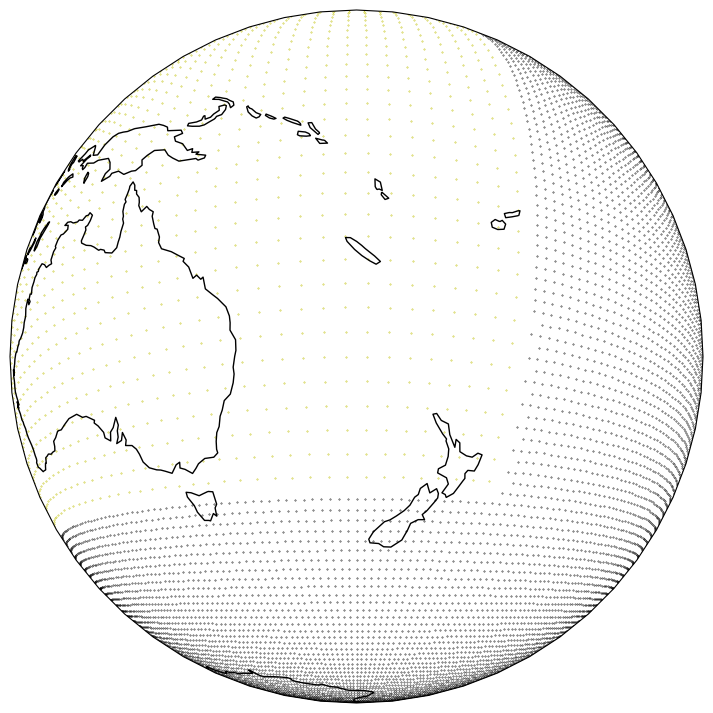

In [46]:
plot_grid(
    ds,
    "cutout_global_lam4_lam3_lam2_lam1_lam6.png",
    s=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    grids=ds.grids,
    c=["g", "r", "b", "c", "y", "k"],
    central_latitude=-30.0, 
    central_longitude=165.0
)

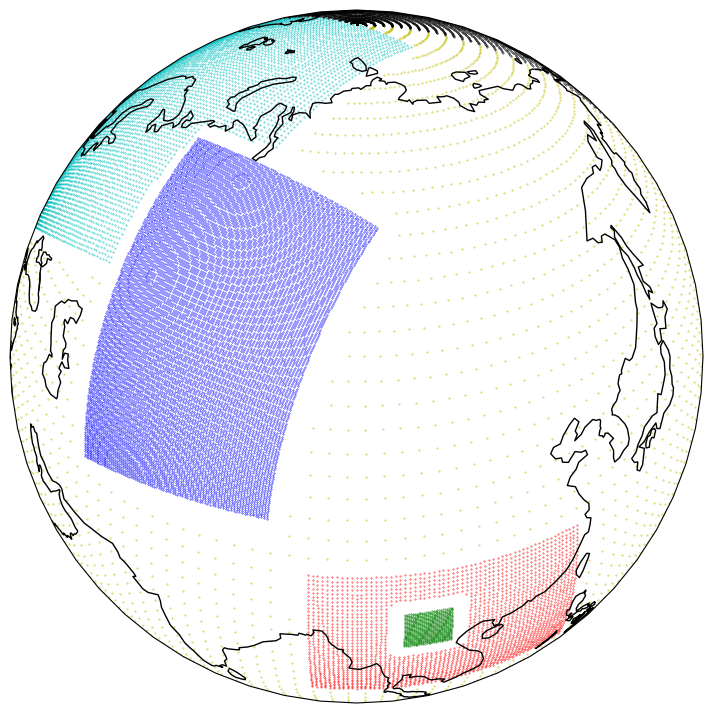

In [47]:
plot_grid(
    ds,
    "cutout_global_lam4_lam3_lam2_lam1_lam6.png",
    s=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    grids=ds.grids,
    c=["g", "r", "b", "c", "y", "k"],
    central_latitude=50.0, 
    central_longitude=95.0
)

### 6) b) ii) Test the parameter `neighbours`.

In [48]:
ds = open_dataset(cutout=[lam_dataset_4, lam_dataset_3, lam_dataset_2,  lam_dataset_1, lam_dataset_6, global_dataset], neighbours=10)


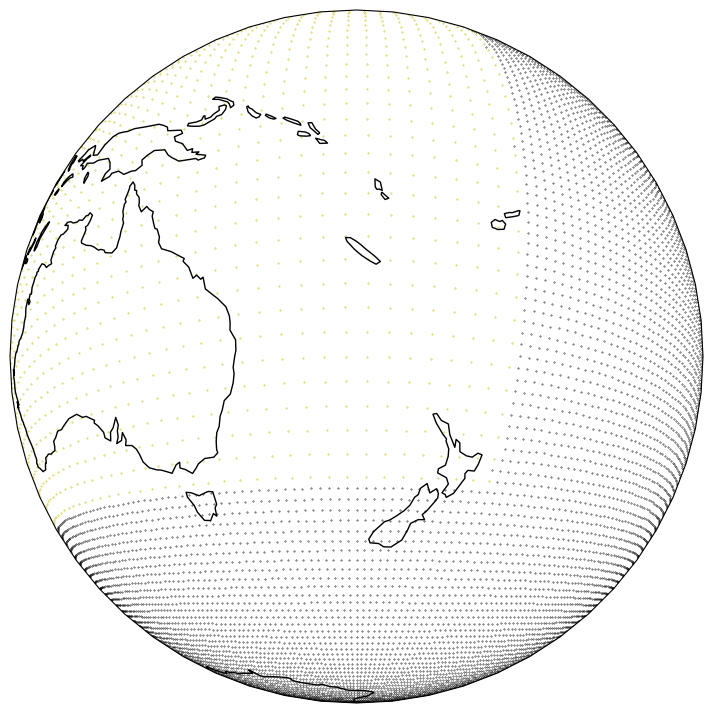

In [49]:
plot_grid(
    ds,
    "cutout_global_lam4_lam3_lam2_lam1_lam6.png",
    s=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    grids=ds.grids,
    c=["g", "r", "b", "c", "y", "k"],
    central_latitude=-30.0, 
    central_longitude=165.0
)

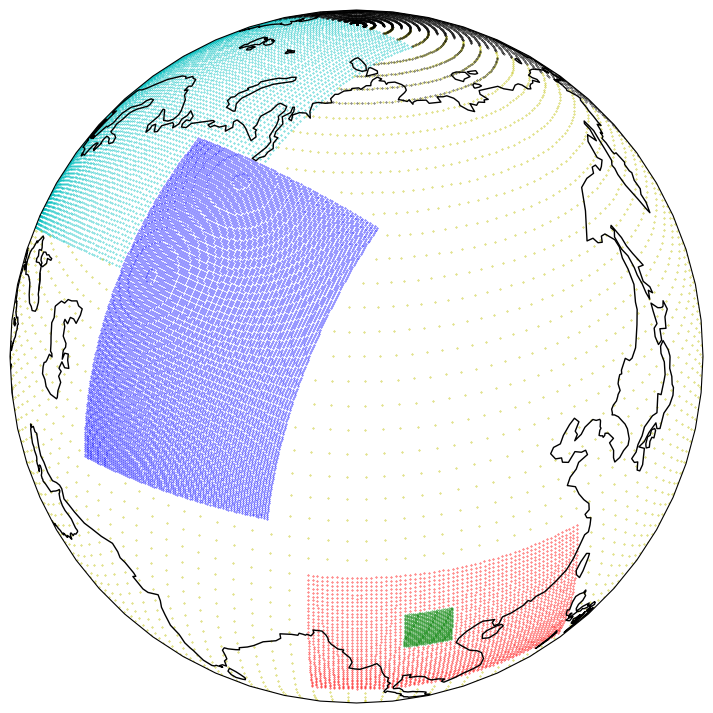

In [50]:
plot_grid(
    ds,
    "cutout_global_lam4_lam3_lam2_lam1_lam6.png",
    s=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    grids=ds.grids,
    c=["g", "r", "b", "c", "y", "k"],
    central_latitude=50.0, 
    central_longitude=95.0
)